# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools ITensors Plots Measurements"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2023-01-04 07:31:49 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package ITensors...
Installing Julia package Plots...
Installing Julia package Measurements...


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × AMD EPYC 7B12
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, znver2)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  LD_PRELOAD = /usr/lib/x86_64-linux-gnu/libtcmalloc.so.4
  JULIA_NUM_THREADS = 2


In [ ]:
using ITensors
using Plots
using Measurements
L = 60;
N = 1;
G² = 1.0;
m = 0.5;
sites = siteinds("Fermion", L);
ITensors.state(::StateName"Plus", ::SiteType"Fermion") = [1/sqrt(2) 1/sqrt(2)]
function GrossNeveu2(l)
    ampo = OpSum();
    for j in 1:l-N
        ampo -= 1im,"C",j,"Cdag",j+N
        ampo += 1im,"C",j+N,"Cdag",j
    end
    for j in 1:N:l-N
        ampo += (G²/2),"C * Cdag",j
    end
    for j in 1:l
        ampo += (m*(-1)^j),"C * Cdag",j
    end
    ψ₀ = randomMPS(sites[1:l],10)
    H = MPO(ampo, sites[1:l])
    sweep = Sweeps([
         "maxdim" "mindim" "cutoff" 
          100      2       1e-16    
          300      10      1e-16    
          700      20      1e-18    
          1000     30      1e-20    
          1024     50      1e-22
         ])
    e, ψ = dmrg(H, ψ₀, sweep)
    return e,ψ,H
end

GrossNeveu2 (generic function with 1 method)

In [ ]:
mps_vector = Vector{MPS}()
mpo_vector = Vector{MPO}()
ovr_vector = Vector{Float64}()
for j in 2:20
    println("j = ",j)
    e₀, ψ₀, H = GrossNeveu2(j)
    nrm = norm(inner(H,ψ₀,H,ψ₀) - inner(ψ₀',H,ψ₀)^2)
    push!(mps_vector, ψ₀)
    push!(mpo_vector, H)
    push!(ovr_vector,nrm)
end

j = 2
After sweep 1 energy=-0.7807190010098665  maxlinkdim=2 maxerr=0.00E+00 time=0.002
After sweep 2 energy=-0.7807764057091392  maxlinkdim=2 maxerr=0.00E+00 time=0.001
After sweep 3 energy=-0.7807764064044064  maxlinkdim=2 maxerr=0.00E+00 time=0.001
After sweep 4 energy=-0.7807764064044146  maxlinkdim=2 maxerr=0.00E+00 time=0.001
After sweep 5 energy=-0.780776406404415  maxlinkdim=2 maxerr=0.00E+00 time=0.001
j = 3
After sweep 1 energy=-1.4287991766825228  maxlinkdim=2 maxerr=0.00E+00 time=0.005
After sweep 2 energy=-1.429757056748452  maxlinkdim=2 maxerr=0.00E+00 time=0.003
After sweep 3 energy=-1.4297616689770258  maxlinkdim=2 maxerr=0.00E+00 time=0.003
After sweep 4 energy=-1.4297616941592417  maxlinkdim=2 maxerr=0.00E+00 time=0.003
After sweep 5 energy=-1.4297616943067113  maxlinkdim=2 maxerr=0.00E+00 time=0.003
j = 4
After sweep 1 energy=-1.6289544399036024  maxlinkdim=4 maxerr=0.00E+00 time=0.005
After sweep 2 energy=-1.6293924468340553  maxlinkdim=4 maxerr=0.00E+00 time=0.005


In [ ]:
for j in 1:length(mps_vector)
    println(inds(mps_vector[j][end])[1])
end

(dim=2|id=619|"Fermion,Site,n=2")
(dim=2|id=947|"Fermion,Site,n=3")
(dim=2|id=287|"Fermion,Site,n=4")
(dim=2|id=509|"Fermion,Site,n=5")
(dim=2|id=908|"Fermion,Site,n=6")
(dim=2|id=513|"Fermion,Site,n=7")
(dim=2|id=106|"Fermion,Site,n=8")
(dim=2|id=20|"Fermion,Site,n=9")
(dim=2|id=57|"Fermion,Site,n=10")
(dim=2|id=993|"Fermion,Site,n=11")
(dim=2|id=608|"Fermion,Site,n=12")
(dim=2|id=517|"Fermion,Site,n=13")
(dim=2|id=945|"Fermion,Site,n=14")
(dim=2|id=385|"Fermion,Site,n=15")
(dim=2|id=628|"Fermion,Site,n=16")
(dim=2|id=159|"Fermion,Site,n=17")
(dim=2|id=304|"Fermion,Site,n=18")
(dim=2|id=255|"Fermion,Site,n=19")
(dim=2|id=343|"Fermion,Site,n=20")


In [ ]:
function OverLap(ψ₁::MPS, ψ₂::MPS)
    len₁ = length(ψ₁)
    len₂ = length(ψ₂)
    v = ITensor(1.0)
    #v1 = state(inds(ψ₂[len₂-1])[1], "Plus")
    v2 = state(inds(ψ₂[len₂])[1], "Plus")
    println(inds(ψ₂[len₂])[1])
    for j in 1:len₁
        v = v*dag(ψ₁[j])*ψ₂[j]
    end
    #v = v*dag(v1)*ψ₂[len₂-1]
    v = v*dag(v2)*ψ₂[len₂]
    return inner(v,v), norm(v)
end

OverLap (generic function with 1 method)

In [ ]:
ol_inner = Vector{Float64}()
ol_norm = Vector{Float64}()
for j in 1:(length(mps_vector)-1)
    inn, nrm = OverLap(mps_vector[j],mps_vector[j+1])
    push!(ol_inner, inn)
    push!(ol_norm, nrm)
end

(dim=2|id=947|"Fermion,Site,n=3")
(dim=2|id=287|"Fermion,Site,n=4")
(dim=2|id=509|"Fermion,Site,n=5")
(dim=2|id=908|"Fermion,Site,n=6")
(dim=2|id=513|"Fermion,Site,n=7")
(dim=2|id=106|"Fermion,Site,n=8")
(dim=2|id=20|"Fermion,Site,n=9")
(dim=2|id=57|"Fermion,Site,n=10")
(dim=2|id=993|"Fermion,Site,n=11")
(dim=2|id=608|"Fermion,Site,n=12")
(dim=2|id=517|"Fermion,Site,n=13")
(dim=2|id=945|"Fermion,Site,n=14")
(dim=2|id=385|"Fermion,Site,n=15")
(dim=2|id=628|"Fermion,Site,n=16")
(dim=2|id=159|"Fermion,Site,n=17")
(dim=2|id=304|"Fermion,Site,n=18")
(dim=2|id=255|"Fermion,Site,n=19")
(dim=2|id=343|"Fermion,Site,n=20")


In [ ]:
err = [sqrt(x) for x in ovr_vector[1:end-1]];
print(length(err))
minimum(err), maximum(err)

18

(7.483238206743512e-9, 0.022847048340492695)

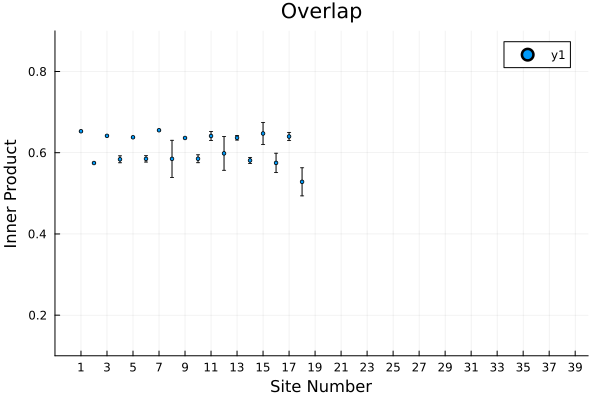

In [ ]:
x = [x for x in 1:length(ol_norm)]
scatter(x,ol_norm .±err*2,
    xlim=(-1,40),xticks=((1:2:40)), 
    ylim=(0.1,0.9), 
    #yticks=((0.4:0.01:0.5)),   
    markersize=2,
    xlabel="Site Number",
    ylabel="Inner Product",
    title="Overlap")
#savefig("one_norm_err.svg")

In [ ]:
using BenchmarkTools

M = rand(2^11, 2^11)

@btime $M * $M;

  465.359 ms (2 allocations: 32.00 MiB)


In [ ]:
try
    using CUDA
catch
    println("No GPU found.")
else
    run(`nvidia-smi`)
    # Create a new random matrix directly on the GPU:
    M_on_gpu = CUDA.CURAND.rand(2^11, 2^11)
    @btime $M_on_gpu * $M_on_gpu; nothing
end

No GPU found.


# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />